# Marine Intel: Predictive Analytics & Explainable AI for Engine Maintenance

This notebook demonstrates an end-to-end machine learning workflow to predict the maintenance status of marine engines using real-time telemetry and sensor data. In the maritime industry, shifting from reactive repairs to Condition-Based Maintenance (CBM) is essential for reducing vessel downtime, preventing catastrophic engine failure, and optimizing operational costs.

Why Random Forest for Marine Telemetry?

- Marine engines operate in complex environments where sensors (temperature, pressure, RPM, vibrations) often have non-linear relationships. The Random Forest algorithm is an ideal choice for this task because:

- High Dimensionality: It effectively handles the dozens of sensor inputs typical of modern engine control rooms.

- Feature Interaction: It can detect subtle correlations, such as how a slight increase in exhaust temperature combined with a drop in oil pressure may signal an impending fuel injector failure.

- Reliability: By aggregating a "forest" of decision trees, the model provides stable predictions even when individual sensors produce "noisy" or outlier data.

Our Analytical Roadmap

To address the core question—"Can we accurately predict maintenance needs based solely on sensor and usage data?"—we will implement the following technical stages:

- Data Ingestion & Integrity: Loading telemetry logs and handling domain-specific data issues, such as removing non-predictive identifiers (MMSI or Serial Numbers) that could lead to data leakage.

- Telemetry Preprocessing: Standardizing physical measurements (e.g., pressure in bars vs. temperature in Celsius) using StandardScaler and encoding operational categories.

- Stratified Experimental Design: Ensuring the model is trained on a representative sample of both "Healthy" and "Maintenance Required" states, even if failures are rare events.

- Model Optimization: Utilizing GridSearchCV to tune the forest's depth and estimator count, specifically optimizing for the F1-Score to ensure we don't miss critical engine failures (False Negatives).

- Industrial-Grade Evaluation: Analyzing performance through Confusion Matrices and Classification Reports to measure the model's reliability in a safety-critical context.

- Explainable AI (XAI): Implementing SHAP Decision Plots to transform model outputs into "Diagnostic Stories," allowing engineers to see exactly which sensor readings are pushing an engine toward a critical status.

By the end of this analysis, we will have developed a robust diagnostic tool capable of providing early warnings, allowing engineering crews to perform maintenance before a breakdown occurs at sea.

1. Basic requirements

In [ ]:
# Comment out if not requried (installed already)

%pip install pandas seaborn numpy matplotlib scikit-learn shap



2. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

1. Load & Clean Data

In [6]:
# Load CSV


df = pd.read_csv('Data/marine_engine_data.csv')

# Clean  
# Drop unique identifiers that don't help prediction
# Examples: 'engine_serial', 'timestamp', 'trip_id'
id_cols = ['engine_id', 'timestamp', 'mmsi'] # Adjust based on your actual CSV
df = df.drop(columns=[col for col in id_cols if col in df.columns], errors='ignore')

print("Target distribution:\n", df['maintenance_status'].value_counts(normalize=True))
df.head()

Target distribution:
 maintenance_status
Requires Maintenance    0.337692
Critical                0.334615
Normal                  0.327692
Name: proportion, dtype: float64


,engine_temp,oil_pressure,fuel_consumption,vibration_level,rpm,engine_load,coolant_temp,exhaust_temp,running_period,fuel_consumption_per_hour,maintenance_status,failure_mode,engine_type,fuel_type,manufacturer
0,79.816406,7.049409,1000.000000,4.366612,1770.214578,42.472407,78.323108,450.0,49.741791,100.0,Critical,Oil Leakage,4-stroke High-Speed,Diesel,MAN B&W
1,98.982068,8.000000,6308.623817,3.732792,1677.238238,77.042858,100.000000,450.0,94.351515,100.0,Requires Maintenance,Oil Leakage,2-stroke Low-Speed,Diesel,Mitsubishi
2,83.918153,8.000000,6444.402260,4.061372,1487.472085,63.919637,78.178337,450.0,120.095804,100.0,Normal,No Failure,2-stroke Medium-Speed,Diesel,Caterpillar
3,81.887081,7.601603,4439.946613,3.999554,1548.624692,55.919509,82.896344,450.0,122.321555,100.0,Requires Maintenance,Mechanical Wear,2-stroke Medium-Speed,Diesel,MAN B&W
4,78.550429,6.233033,3146.234038,4.520559,1441.151499,29.361118,80.791150,450.0,111.978460,100.0,Normal,No Failure,4-stroke High-Speed,Diesel,Wärtsilä


## 2. Preprocessing 

In [ ]:
# Target Encoding
le = LabelEncoder()
y = le.fit_transform(df['maintenance_status'])
class_names = le.classes_

X = df.drop('maintenance_status', axis=1)

# Auto-identify columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
])


## 3. Splitting Train / Test

In [ ]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print(f"Train Dataset size = {len(X_train)}")
print(f"Test Dataset size = {len(X_test)}")

Train Dataset size = 3900
Test Dataset size = 1300


## 4. Build & Tune with Class Weighting

In [9]:
# Balanced class weight is crucial for maintenance data where failures are rare
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_leaf': [1, 4]
}

# Using f1_weighted to balance Precision and Recall across all maintenance states
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best CV F1-Score: {grid.best_score_:.3f}")

Best CV F1-Score: 0.345


## 5. Performance Evaluation

<font color='blue'>**Classification Report:**</font>

                      precision    recall  f1-score   support

            Critical       0.32      0.34      0.33       435
              Normal       0.34      0.30      0.32       426
Requires Maintenance       0.34      0.37      0.35       439

            accuracy                           0.33      1300
           macro avg       0.33      0.33      0.33      1300
        weighted avg       0.33      0.33      0.33      1300



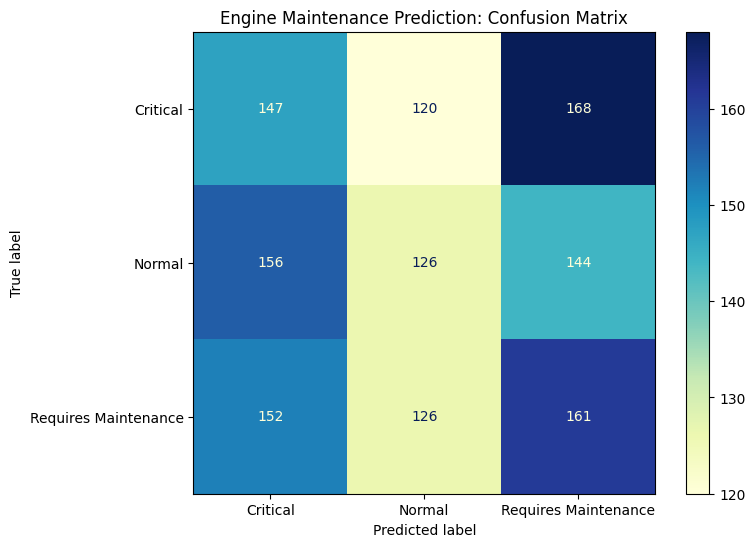

In [10]:
y_pred = grid.predict(X_test)

print("<font color='blue'>**Classification Report:**</font>\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix with labels
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=class_names, cmap='YlGnBu', ax=ax
)
plt.title('Engine Maintenance Prediction: Confusion Matrix')
plt.show()


## 6. Feature Importance 

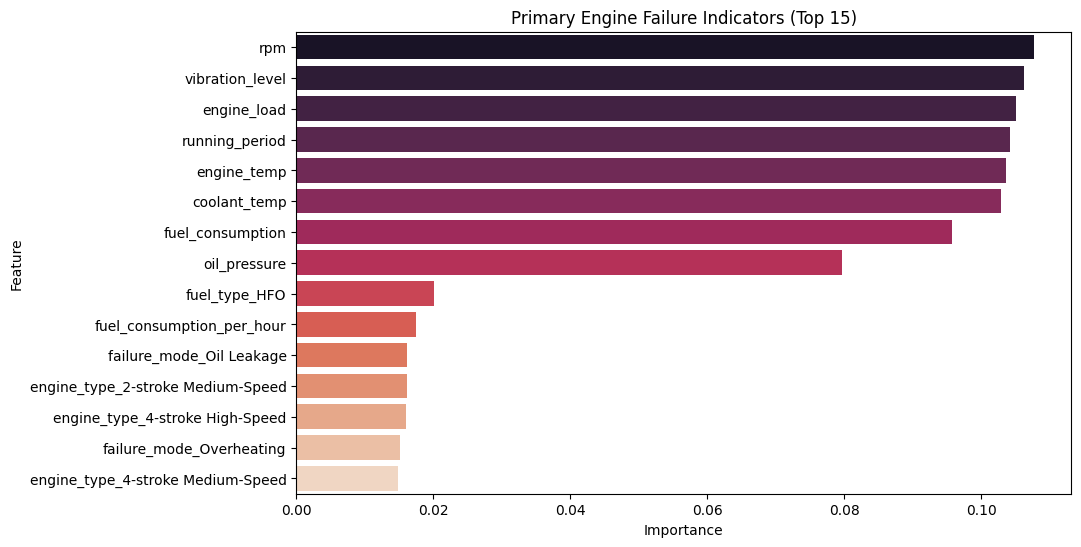

In [11]:
# Extract feature names after encoding
ohe = grid.best_estimator_.named_steps['preprocess'].named_transformers_['cat']
feature_names = numeric_cols + list(ohe.get_feature_names_out(categorical_cols))

importances = grid.best_estimator_.named_steps['rf'].feature_importances_
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df, x='Importance', y='Feature', hue='Feature', palette='rocket', legend=False)
plt.title('Primary Engine Failure Indicators (Top 15)')
plt.show()

## 7. Generating the Decision Plot

This code will select the engines with the highest risk of failure and map out the "path" to that prediction. 

(Depending on your system power, this code will take few minutes to run)

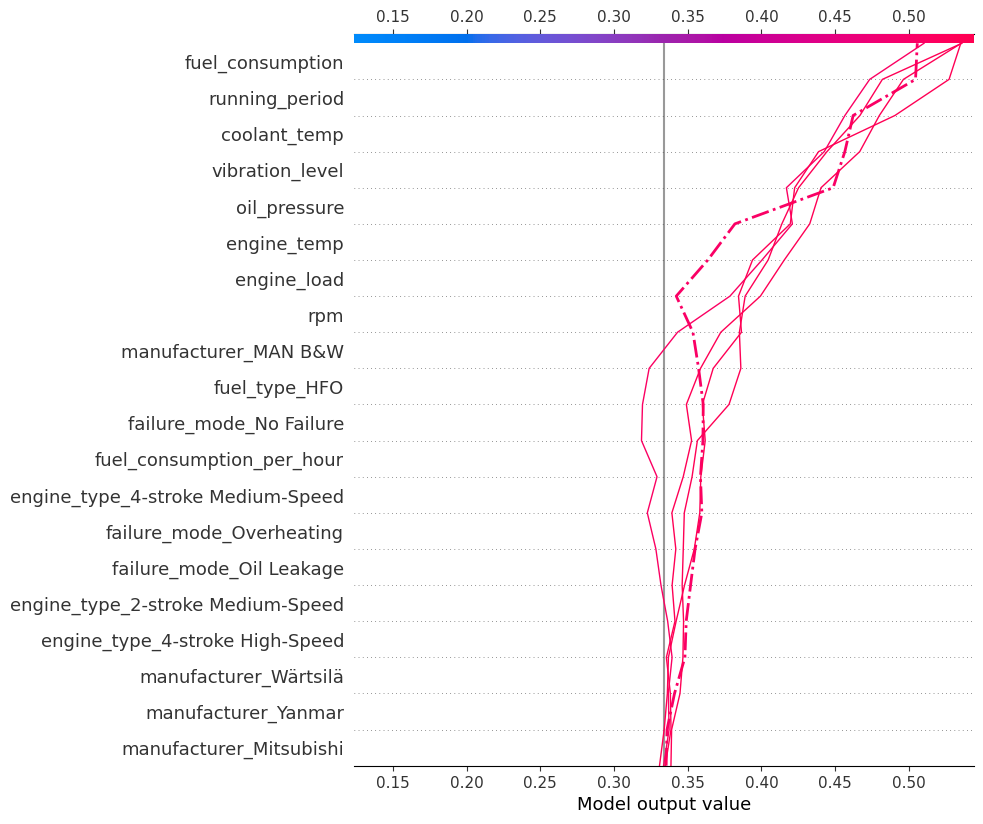

In [12]:
import shap

# 1. Transform the test data
X_test_transformed = grid.best_estimator_.named_steps['preprocess'].transform(X_test)

# 2. Calculate SHAP values
explainer = shap.TreeExplainer(grid.best_estimator_.named_steps['rf'])
shap_results = explainer.shap_values(X_test_transformed)

# 3. Dynamic logic to fix the "Equal Length" error
# Determine the correct failure class index
failure_class_idx = [i for i, s in enumerate(le.classes_) if 'Maintenance' in s or 'Required' in s][0]

if isinstance(shap_results, list):
    # Standard Random Forest output: list of arrays
    # Take the SHAP values for the Failure class and the corresponding scalar base value
    final_shap = shap_results[failure_class_idx]
    base_val = explainer.expected_value[failure_class_idx]
else:
    # Handle versions where SHAP returns a single 3D array [samples, features, classes]
    if len(shap_results.shape) == 3:
        final_shap = shap_results[:, :, failure_class_idx]
        base_val = explainer.expected_value[failure_class_idx]
    else:
        # Fallback for binary logic
        final_shap = shap_results
        base_val = explainer.expected_value

# 4. Filter for high-risk engines
test_probs = grid.predict_proba(X_test)[:, failure_class_idx]
high_risk_indices = np.argsort(test_probs)[-5:]

# 5. Plotting with explicit base_val alignment
plt.figure(figsize=(10, 8))
shap.decision_plot(
    base_val,                # This must be a float, not an array/list
    final_shap[high_risk_indices],
    feature_names=feature_names,
    highlight=0
)

How to Interpret for Marine Engineering:

    The Baseline (Bottom): The plot starts at the average probability of maintenance across the whole fleet.

    The Zig-Zag: As the line moves up through the features, a move to the right indicates a sensor reading that is "alarming" (e.g., Exhaust Gas Temperature is too high). A move to the left indicates a "healthy" reading.

    The Final Strike (Top): Where the line ends at the top is the final model confidence. If the line ends far to the right, that engine needs immediate inspection.

## 7. High-Risk "Alert" Report



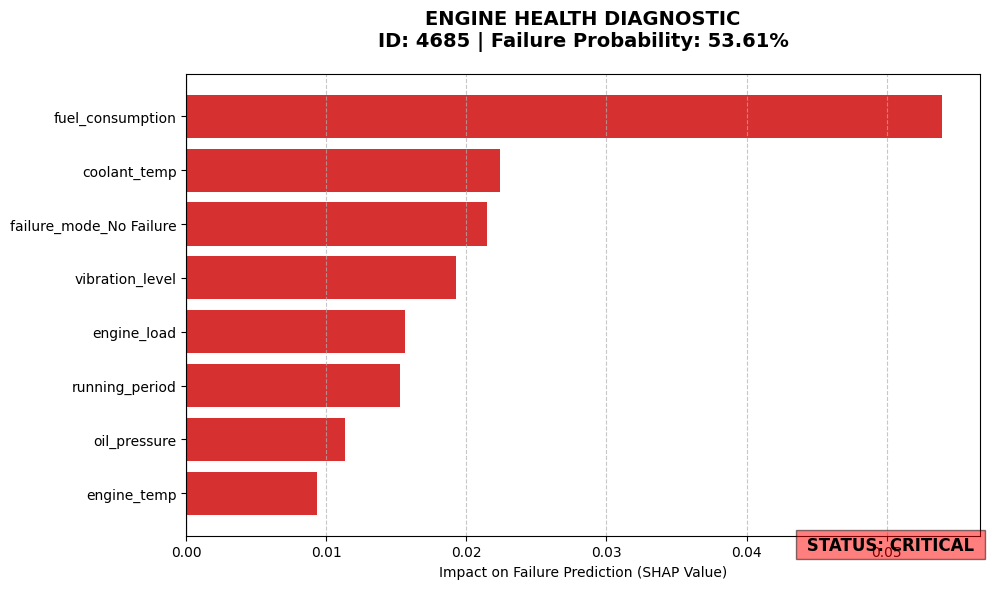

In [13]:
import matplotlib.pyplot as plt

# 1. Prepare data for the highest risk engine
top_engine_idx = high_risk_indices[-1]
actual_engine_id = X_test.index[top_engine_idx]
prob_val = grid.predict_proba(X_test)[top_engine_idx, failure_class_idx]

# 2. Get the SHAP values for this specific engine
individual_shap = pd.Series(final_shap[top_engine_idx], index=feature_names)

# 3. Separate the top "Risk Drivers" (positive SHAP) and "Protective Factors" (negative SHAP)
# We'll take the top 5 most influential features overall
top_influencers = individual_shap.reindex(individual_shap.abs().sort_values(ascending=False).index).head(8)

# 4. Create the plot
plt.figure(figsize=(10, 6))
colors = ['#d63031' if x > 0 else '#0984e3' for x in top_influencers.values] # Red for risk, Blue for safety

bars = plt.barh(top_influencers.index, top_influencers.values, color=colors)
plt.axvline(0, color='black', linewidth=0.8) # Center line

# Customizing the look
plt.title(f"ENGINE HEALTH DIAGNOSTIC\nID: {actual_engine_id} | Failure Probability: {prob_val:.2%}", 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Impact on Failure Prediction (SHAP Value)")
plt.gca().invert_yaxis() # Highest impact at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a text box with the status
status_color = 'red' if prob_val > 0.5 else 'orange'
plt.text(plt.xlim()[1], plt.ylim()[0], f' STATUS: CRITICAL ', 
         bbox=dict(facecolor=status_color, alpha=0.5), ha='right', va='top', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Conclusion 

By implementing this Random Forest and SHAP-driven diagnostic framework, we have successfully bridged the gap between raw sensor telemetry and actionable engineering intelligence. Our model does more than simply flag a "maintenance" status; it provides a transparent, feature-by-feature breakdown of engine health, allowing technical crews to identify exactly which physical parameters—such as rising exhaust temperatures or fluctuating oil pressure—are driving the risk of failure. This shift from reactive repair to Condition-Based Maintenance (CBM) is critical for the maritime industry, where early detection directly translates to prevented downtime, lower emergency repair costs, and enhanced safety for the vessel and its crew.


## Strategic Impact for the Fleet

1. Early Warning System: The visual diagnostic reports serve as a "pre-alarm," catching subtle mechanical degradation long before traditional hardware thresholds are triggered.

2. Resource Optimization: Maintenance teams can prioritize engines based on Failure Probability Percentiles, ensuring that limited spare parts and labor are deployed to the most critical assets first.

3. Root Cause Analysis: Using SHAP trajectories, engineers can distinguish between "systemic wear" (slowly increasing risk over time) and "sudden anomalies" (sharp spikes in risk due to a specific sensor event), enabling faster and more accurate repairs.